# EDCWRN: Efficient Deep Clustering with the Weight of Representations and the help of Neighbors


In [ ]:
from google.colab import drive
drive.mount('/content/clustering')

In [3]:
import numpy as np
from time import time
import keras.backend as K
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Reshape
from keras.models import Model
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans, MiniBatchKMeans,k_means
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize
np.random.seed(10)

In [4]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi_fun = normalized_mutual_info_score
ari_fun = adjusted_rand_score


def acc_fun (y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [5]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = 10

11501568/11490434 [==============================] - 1s 0us/step


In [6]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


## Hyper-params

In [7]:
dims = [x.shape[-1], 500, 500, 2000, 10]

pretrain_epochs = 500
batch_size = 256
save_dir = '/content/clustering/MyDrive/clustering'
landa = 0.1
a_b=[1.93, 0.79]
beta = 2
alpha = 1
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [8]:
autoencoder, encoder = autoencoder(dims, init=init)

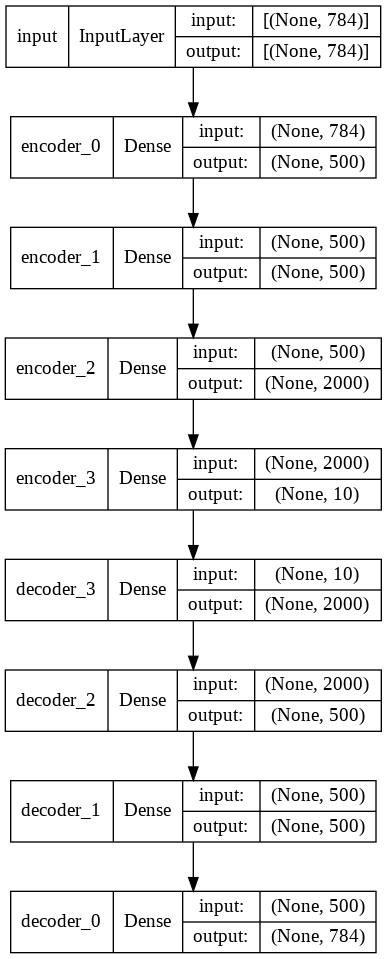

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

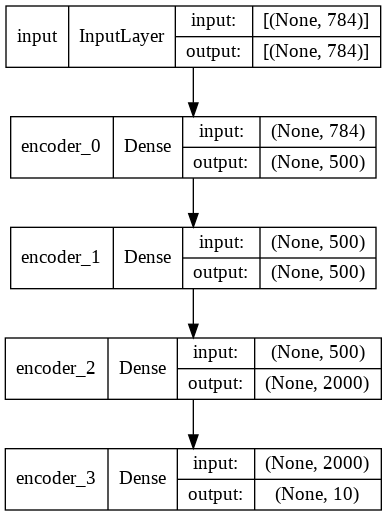

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 

## Pretrain auto-encoder

In [11]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=10, zoom_range=0.0)
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
maxiter = 500*batch_size
index_array = np.arange(x.shape[0])
loss = 0
index = 0
for ite in range(int(maxiter)):
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]

    # data agumentation
    x_reshape = np.reshape(x[idx],(len(x[idx]),32,32,1))
    datagen.fit(x_reshape)

    for X_batch, y_batch in datagen.flow(x_reshape, x_reshape, batch_size):
      X_batch = np.reshape(X_batch,(X_batch.shape[0],32*32*1))
      loss = autoencoder.train_on_batch(x=X_batch, y=X_batch)
      break

    if (index + 1) * batch_size <= x.shape[0]:
      index = index + 1  
    else: 
      index = 0
    if ite%1000==0:
      print('iter = ',ite, 'loss = ',loss)
      autoencoder.save_weights('/content/clustering/MyDrive/clustering/ae_augmentation_weights.h5)

### Load the pre-trained auto encoder weights

In [12]:
autoencoder.load_weights('/content/clustering/MyDrive/clustering/ae_augmentation_weights.h5')

## Build clustering model

### ClusteringLayer

In [13]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, FeatureWeight, weights=None, a=1.0, b=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.FeatureWeight = FeatureWeight
        self.a = a
        self.b = b
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """

        global FeatureWeight
        q = (1 + self.a * (K.sum((self.FeatureWeight) * K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) ** (self.b))) ** (-1)  
        FeatureWeight = K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters) * K.expand_dims(q**2, axis=2)  ,axis=0)
        FeatureWeight = K.transpose(K.transpose(FeatureWeight) / K.sum(FeatureWeight, axis=1))
                   
        return q 

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [14]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [15]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001 # tolerance threshold to stop training

## Model to train clustering and autoencoder at same time(Fully connected)
Multiple outputs model.

In [16]:
dims = [x.shape[-1], 500, 500, 2000, 10]
initial = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = '/content/clustering/MyDrive/clustering'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [17]:
import keras
from keras import layers

In [18]:
def autoencoder_Neighbor(dims, act='relu', init='glorot_uniform'):
      n_stacks = len(dims) - 1

      # input
      input_shape = (28, 28, 1)
      input_img = Input(shape=(input_shape), name='input')
      x = input_img
      x = Reshape((dims[0],),name='Reshape_input')(x)

      # internal layers in encoder
      for i in range(n_stacks-1):
          x = layers.Dense(dims[i + 1], activation=act, kernel_initializer=init, name='image_encoder_%d' % i)(x) 

      # hidden layer
      x = layers.Dense(dims[-1], kernel_initializer=init, name='image_encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

      # Inpute Neighbors
      Neighbor1 = keras.Input(shape=(input_shape), name='input_Neighbor1')
      Neighbor2 = keras.Input(shape=(input_shape), name='input_Neighbor2')


      inp_Neighbor1 = Neighbor1
      inp_Neighbor2 = Neighbor2


      reshape = Reshape((dims[0],),name='Reshape_input_Neighbor')
      dense1 = layers.Dense(dims[1], activation=act, kernel_initializer=init, name='encoder_Neighbor_%d' % 0)  
      dense2 = layers.Dense(dims[2], activation=act, kernel_initializer=init, name='encoder_Neighbor_%d' % 1) 
      dense3 = layers.Dense(dims[3], activation=act, kernel_initializer=init, name='encoder_Neighbor_%d' % 2) 

      inp_Neighbor1 = reshape     (inp_Neighbor1)   
      inp_Neighbor2 = reshape     (inp_Neighbor2)

      
      inp_Neighbor1 = dense1     (inp_Neighbor1)   
      inp_Neighbor2 = dense1     (inp_Neighbor2)


      inp_Neighbor1 = dense2     (inp_Neighbor1)   
      inp_Neighbor2 = dense2     (inp_Neighbor2)


      inp_Neighbor1 = dense3     (inp_Neighbor1)   
      inp_Neighbor2 = dense3     (inp_Neighbor2)


      # hidden layer
      encoded_last = layers.Dense(dims[-1], kernel_initializer=init, name='encoder_Neighbor_%d' % (n_stacks - 1))  # hidden layer, features are extracted from here

      inp_Neighbor1 = encoded_last     (inp_Neighbor1)   
      inp_Neighbor2 = encoded_last     (inp_Neighbor2)

      out_encoder_Neighbor = layers.Maximum()([inp_Neighbor1,inp_Neighbor2]) 
                                                                               
      # add Final encoder
      encoded = layers.add([x ,out_encoder_Neighbor],name='add_inputs')

      # internal layers in decoder
      x = layers.Dense(dims[3], activation=act, kernel_initializer=init, name='decoder_%d' % 3)(encoded)
      x = layers.Dense(dims[2], activation=act, kernel_initializer=init, name='decoder_%d' % 2)(x)
      x = layers.Dense(dims[1], activation=act, kernel_initializer=init, name='decoder_%d' % 1)(x)

      # output
      x = layers.Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)

      decoded = Reshape((28,28,1),name='Reshape_output')(x)                     

      encoderWithNeighbors = keras.Model(inputs=[input_img,Neighbor1,Neighbor2], outputs=encoded, name='encoderWithNeighbors')     
      autoencoderWithNeighbors = keras.Model(inputs=[input_img,Neighbor1,Neighbor2], outputs=decoded, name='autoencoderWithNeighbors') 
      return autoencoderWithNeighbors, encoderWithNeighbors


In [19]:
autoencoderWithNeighbors, encoderWithNeighbors = autoencoder_Neighbor(dims)

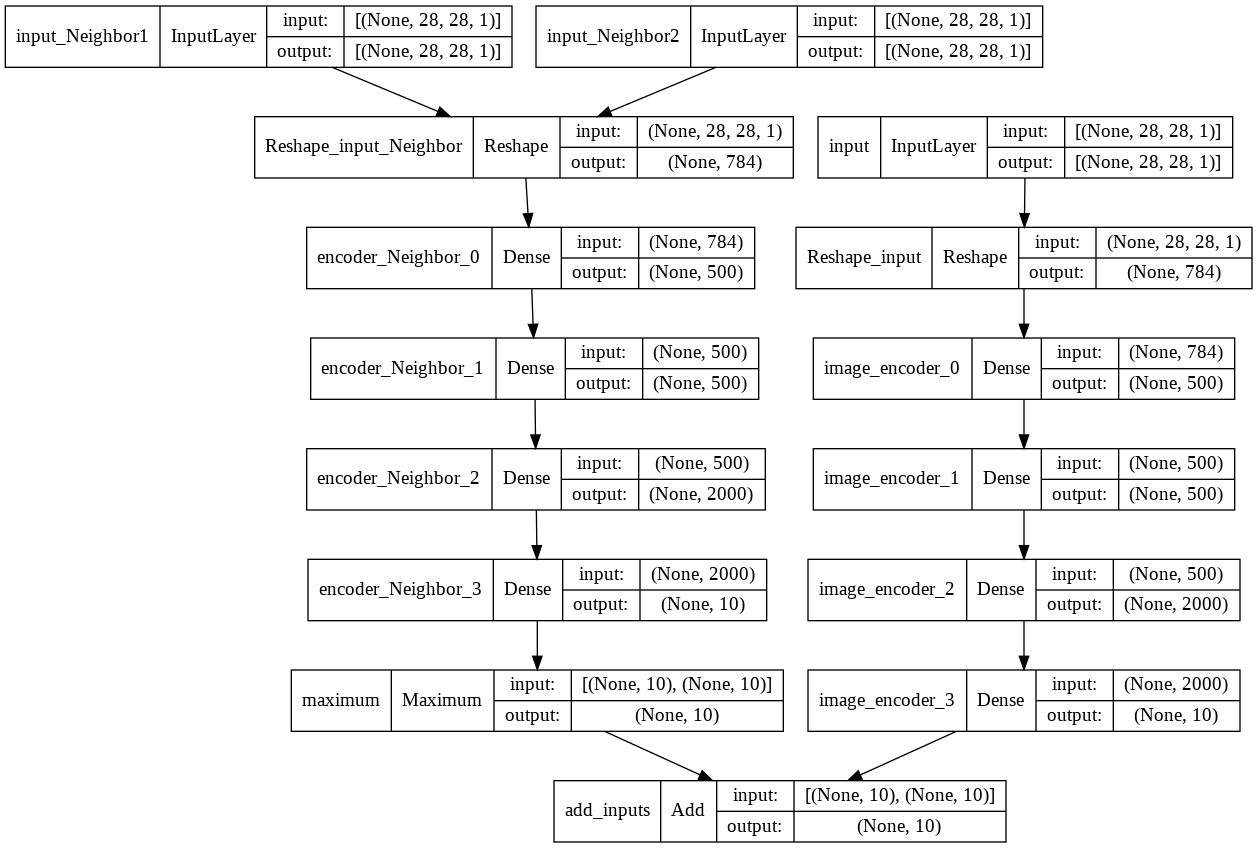

In [20]:
import tensorflow
tensorflow.keras.utils.plot_model(encoderWithNeighbors, "multi_input_and_output_model.png", show_shapes=True)

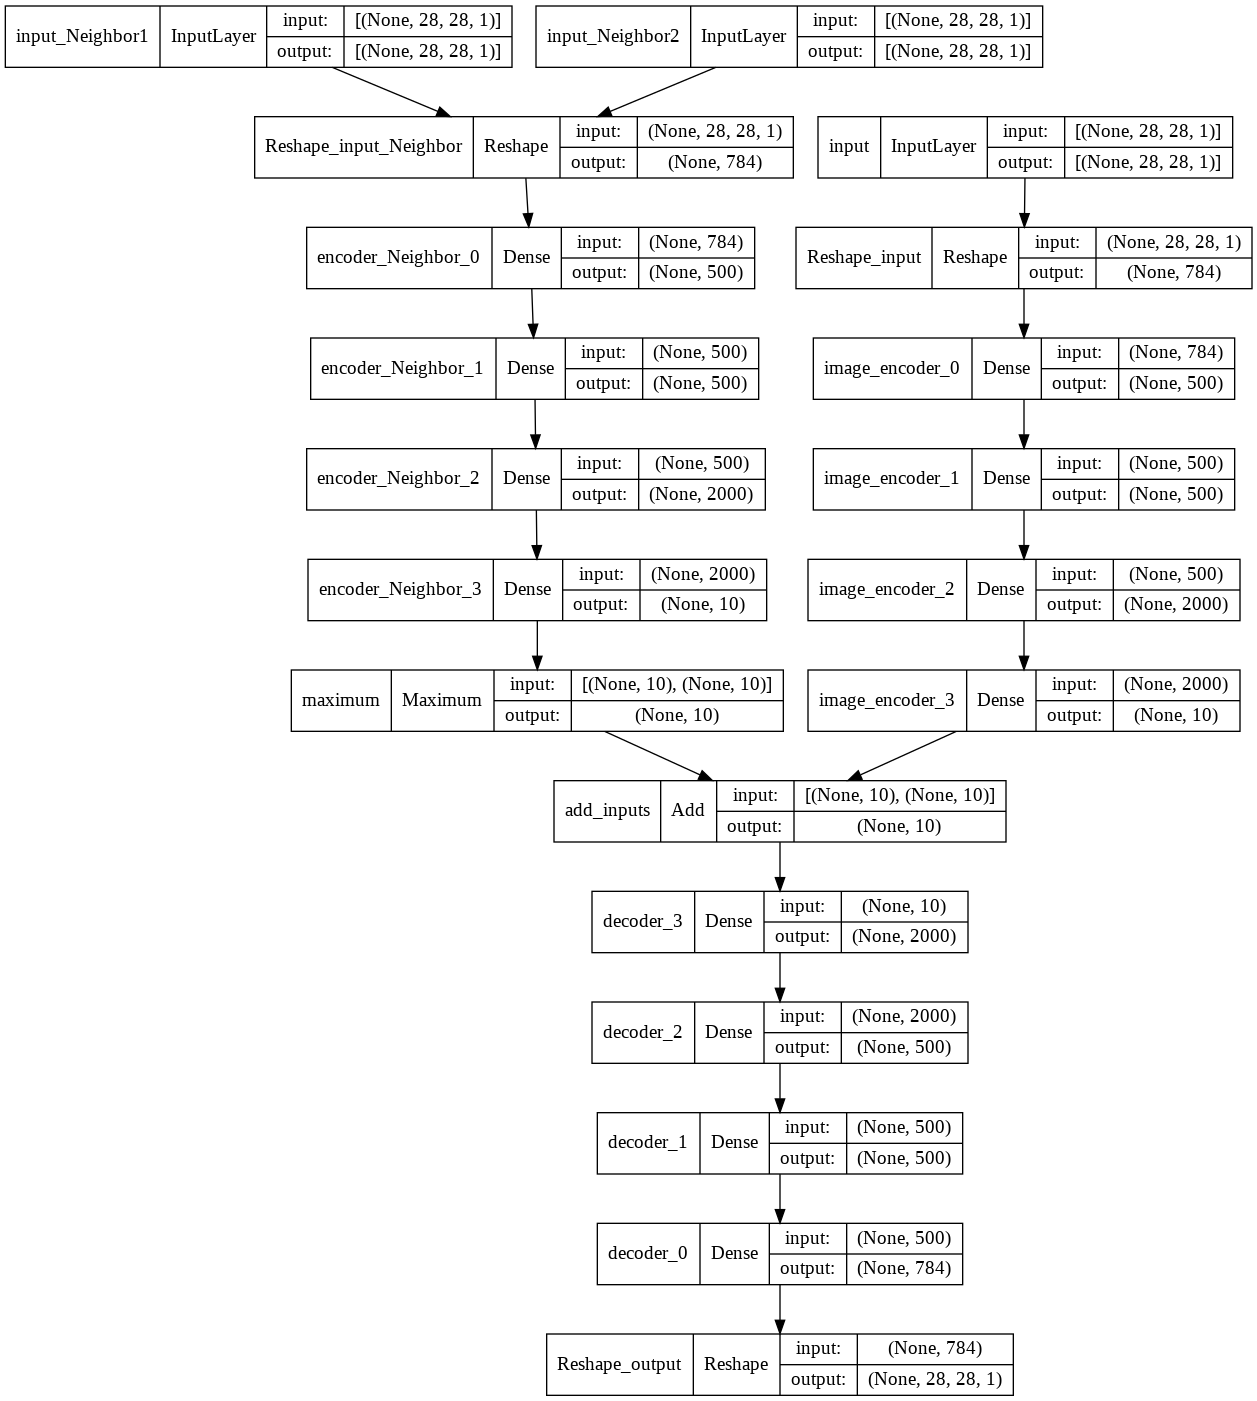

In [21]:
tensorflow.keras.utils.plot_model(autoencoderWithNeighbors, "multi_input_and_output_model.png", show_shapes=True)

In [22]:
input = autoencoder.get_layer(name='input').get_weights()
encoder_0 = autoencoder.get_layer(name='encoder_0').get_weights()
encoder_1 = autoencoder.get_layer(name='encoder_1').get_weights()
encoder_2 = autoencoder.get_layer(name='encoder_2').get_weights()
encoder_3 = autoencoder.get_layer(name='encoder_3').get_weights()
decoder_0 = autoencoder.get_layer(name='decoder_0').get_weights()
decoder_1 = autoencoder.get_layer(name='decoder_1').get_weights()
decoder_2 = autoencoder.get_layer(name='decoder_2').get_weights()
decoder_3 = autoencoder.get_layer(name='decoder_3').get_weights()

# Image weight
autoencoderWithNeighbors.get_layer(name='input').set_weights(input)
autoencoderWithNeighbors.get_layer(name='image_encoder_0').set_weights(encoder_0)
autoencoderWithNeighbors.get_layer(name='image_encoder_1').set_weights(encoder_1)
autoencoderWithNeighbors.get_layer(name='image_encoder_2').set_weights(encoder_2)
autoencoderWithNeighbors.get_layer(name='image_encoder_3').set_weights(encoder_3)

autoencoderWithNeighbors.get_layer(name='decoder_0').set_weights(decoder_0)
autoencoderWithNeighbors.get_layer(name='decoder_1').set_weights(decoder_1)
autoencoderWithNeighbors.get_layer(name='decoder_2').set_weights(decoder_2)
autoencoderWithNeighbors.get_layer(name='decoder_3').set_weights(decoder_3)

autoencoderWithNeighbors.get_layer(name='encoder_Neighbor_0').set_weights(encoder_0)
autoencoderWithNeighbors.get_layer(name='encoder_Neighbor_1').set_weights(encoder_1)
autoencoderWithNeighbors.get_layer(name='encoder_Neighbor_2').set_weights(encoder_2)
autoencoderWithNeighbors.get_layer(name='encoder_Neighbor_3').set_weights(encoder_3)

autoencoderWithNeighbors.get_layer(name='input_Neighbor1').set_weights(input)
autoencoderWithNeighbors.get_layer(name='input_Neighbor2').set_weights(input)

# Image weight (encoder)
encoderWithNeighbors.get_layer(name='input').set_weights(input)
encoderWithNeighbors.get_layer(name='image_encoder_0').set_weights(encoder_0)
encoderWithNeighbors.get_layer(name='image_encoder_1').set_weights(encoder_1)
encoderWithNeighbors.get_layer(name='image_encoder_2').set_weights(encoder_2)
encoderWithNeighbors.get_layer(name='image_encoder_3').set_weights(encoder_3)

encoderWithNeighbors.get_layer(name='encoder_Neighbor_0').set_weights(encoder_0)
encoderWithNeighbors.get_layer(name='encoder_Neighbor_1').set_weights(encoder_1)
encoderWithNeighbors.get_layer(name='encoder_Neighbor_2').set_weights(encoder_2)
encoderWithNeighbors.get_layer(name='encoder_Neighbor_3').set_weights(encoder_3)

encoderWithNeighbors.get_layer(name='input_Neighbor1').set_weights(input)
encoderWithNeighbors.get_layer(name='input_Neighbor2').set_weights(input)

In [23]:
FeatureWeight = np.ones((n_clusters,dims[-1]),dtype='float32')/dims[-1]
clustering_layer = ClusteringLayer(n_clusters,FeatureWeight, a=a_b[0], b=a_b[1], name='clustering')(encoderWithNeighbors.output)
model = keras.Model(inputs=encoderWithNeighbors.input, outputs=[clustering_layer, autoencoderWithNeighbors.output])

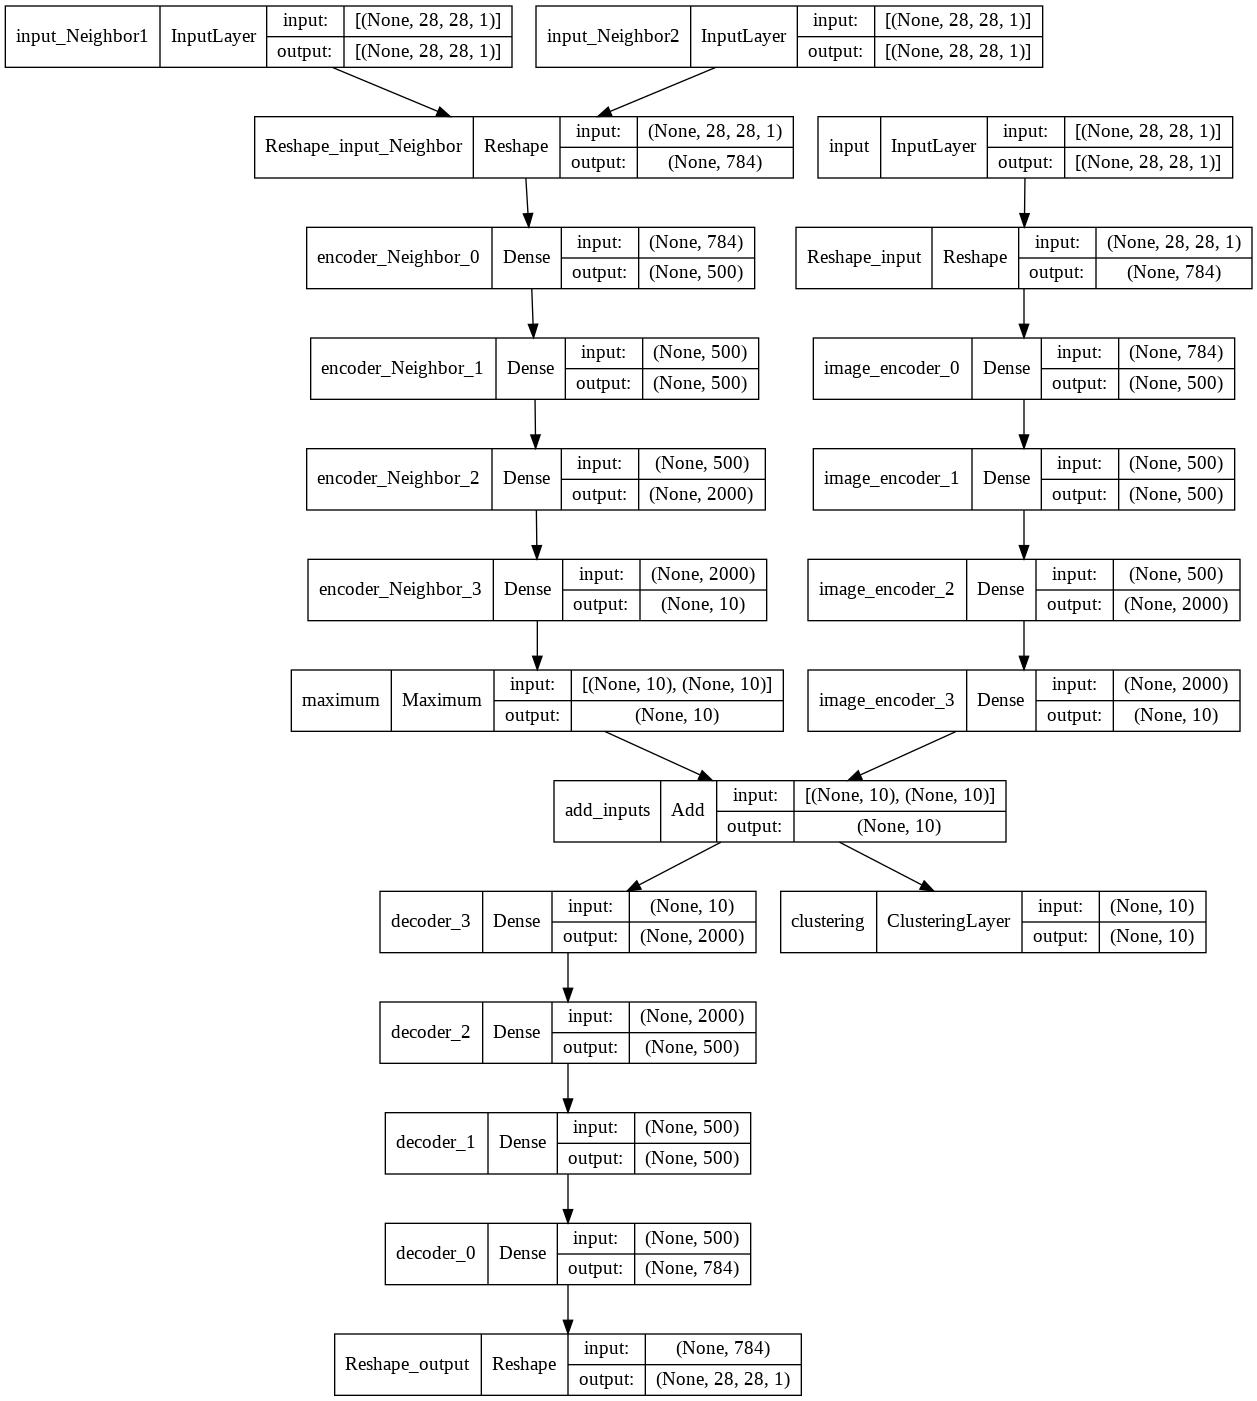

In [24]:
import tensorflow
tensorflow.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

### Initialize cluster centers using k-means

In [25]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=3,metric='euclidean')

In [26]:
x = np.reshape(x,(len(x),28,28,1))

In [27]:
kmeans = KMeans(n_clusters=n_clusters, n_init=150, n_jobs=10, init='k-means++')
y_pred = kmeans.fit_predict(encoderWithNeighbors.predict([x,x,x]))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [28]:
b1= -0.9
b2 = b1/2
treshold_1 = 0.9

beta_dley_rate =  0.09

Prev_Number_Unreliable = 1000000000000000
Prev_Number_reliable = 0

tre_Reconstraction = 1
tre_clustering = 0.1 
loss_dley_rate = 0

In [29]:
model.compile(loss=['CategoricalCrossentropy', 'mse'], loss_weights=[tre_clustering, tre_Reconstraction], optimizer=pretrain_optimizer)

In [30]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, rotation_range=10, zoom_range=0.1)

In [31]:
def generate_data_generator_for_two_images(x_reliablei,Nei1_reliablei,Nei2_reliablei,batch_size):
    genX1 = datagen.flow(x_reliablei, shuffle=False, batch_size= batch_size)
    genX2 = datagen.flow(Nei1_reliablei, shuffle=False, batch_size= batch_size)
    genX3 = datagen.flow(Nei2_reliablei, shuffle=False, batch_size= batch_size)
    
    X1i = genX1.next()
    X2i = genX2 .next()
    X3i = genX3 .next()
   
    return X1i, X2i , X3i

In [32]:
# computing Feature weighting
def FeatureWeight_calculator (q , alpha, x, beta, landa):
  neigh.fit(q)
  _,Neighbors_list=neigh.kneighbors(q)

  q, _  = model.predict([x,x[Neighbors_list[:,1]],
                       x[Neighbors_list[:,2]],],
                       verbose=0)

  mu = model.get_layer(name='clustering').get_weights()
  mu = np.reshape(mu,(n_clusters,dims[-1]))

  extract = Model(inputs = model.input, outputs = model.get_layer('add_inputs').output)
  z = extract.predict([x, x[Neighbors_list[:,1]], x[Neighbors_list[:,2]]])
  # z = extract.predict([x, x, x])

  FeatureVar = landa/np.var(z,axis=0)
  dWkm=np.zeros((n_clusters,dims[-1]))

  for j in range (n_clusters):
    dWkm[j] = np.dot(np.transpose(q[:,j]**2) , K.square(z - mu[j]))
  
  tmp1=np.zeros((n_clusters,dims[-1]))
  for j in range (dims[-1]):
    tmp2 = (dWkm / K.expand_dims(dWkm[:,j],axis=1))**(1/(beta-1))
    tmp1=tmp1+tmp2

  FeatureWeight = np.array(1/tmp1, dtype = 'float32')
  
  return FeatureWeight

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        model.save_weights(save_dir + '/final_MNIST.h5')

        if ite==0:
          q, _  = model.predict([x,x,x], verbose=0)
          extract = Model(inputs = model.input, outputs = model.get_layer('add_inputs').output)
          z = extract.predict([x, x, x])
        else:
          neigh.fit(z)
          _,Neighbors_list=neigh.kneighbors(z)
          q, _  = model.predict([x,x[Neighbors_list[:,1]], x[Neighbors_list[:,2]],], verbose=0)
          
        p = target_distribution(q)  # update the auxiliary target distribution p
               
        reliableindex, _ = np.unique(np.unique(np.where(np.sort(q,axis=1)[:,-1] - np.sort(q,axis=1)[:,-2]>=b2), np.where(np.max(q,axis=1)>=b1)),
                           np.unique(np.where(np.sort(p,axis=1)[:,-1] - np.sort(p,axis=1)[:,-2]>=b2), np.where(np.max(p,axis=1)>=b1)))

        print('Number of reliable samples:', len(q[reliableindex]) )
        print('Number of unreliable samples:', len(q)-len(q[reliableindex]) )
        
        Number_Unreliable = len(q)-len(q[reliableindex])
        Number_reliable = len(q[reliableindex])

        ########################################################################
        if (Number_reliable < Prev_Number_reliable) and ite!=0 and (0<=b1<=1) and (0<=b2<=1) and Number_reliable!=70000:
            b1 = b1-beta_dley_rate
            b2 = b2-beta_dley_rate

        ########################################################################
        tre_Reconstraction = tre_Reconstraction - loss_dley_rate
        tre_clustering = tre_clustering + loss_dley_rate
        model.compile(loss=['CategoricalCrossentropy', 'mse'], loss_weights=[tre_clustering, tre_Reconstraction], optimizer=pretrain_optimizer)
        ########################################################################
               
        print('treshold of Reconstraction = ', tre_Reconstraction ,'treshold of clustering = ', tre_clustering)
        print('Beta1 = ', b1 ,'Beta2 = ', b2)
        Prev_Number_Unreliable = Number_Unreliable
        Prev_Number_reliable = Number_reliable

        # evaluate the clusterig performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(acc_fun(y, y_pred), 5)
            nmi = np.round(nmi_fun(y, y_pred), 5)
            ari = np.round(ari_fun(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break

    idx = index_array[index * batch_size: min((index+1) * batch_size, reliableindex.shape[0])]

    neigh.fit(z[reliableindex[idx]])
    _,Neighbors_list=neigh.kneighbors(z[reliableindex[idx]])

   
    X1, X2, X3, = generate_data_generator_for_two_images (x[reliableindex[idx]],
                                                             x[Neighbors_list[:,1]],
                                                             x[Neighbors_list[:,2]],batch_size)
   
    loss = model.train_on_batch(x=[X1, X2, X3], y=[p[reliableindex[idx]], X1])

    z[idx] = extract.predict([x[reliableindex[idx]],
                        x[Neighbors_list[:,1]],
                        x[Neighbors_list[:,2]]], verbose=0)
    
    index = index + 1 if (index + 1) * batch_size <= reliableindex.shape[0] else 0

### Load the clustering model trained weights

In [35]:
model.load_weights(save_dir + '/final_MNIST.h5')

### Final Evaluation

In [36]:
FeatureWeight = FeatureWeight_calculator (q , alpha, x, beta, landa)

In [37]:
extract = Model(inputs = model.input, outputs = model.get_layer('add_inputs').output)
neigh.fit(z)
_,Neighbors_list=neigh.kneighbors(z)

z = extract.predict([x,x[Neighbors_list[:,1]],
                       x[Neighbors_list[:,2]]])

In [38]:
pip install umap-learn

     |████████████████████████████████| 86 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 28.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=cd0c48d90f805fd71693d5142827f262a1f15871b15cabdf080e69b20b5e6610
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=4166c6884361e94a4e4d6db93ad4fbf8e42e9e531c8dd9830421c27a81ea0c13
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


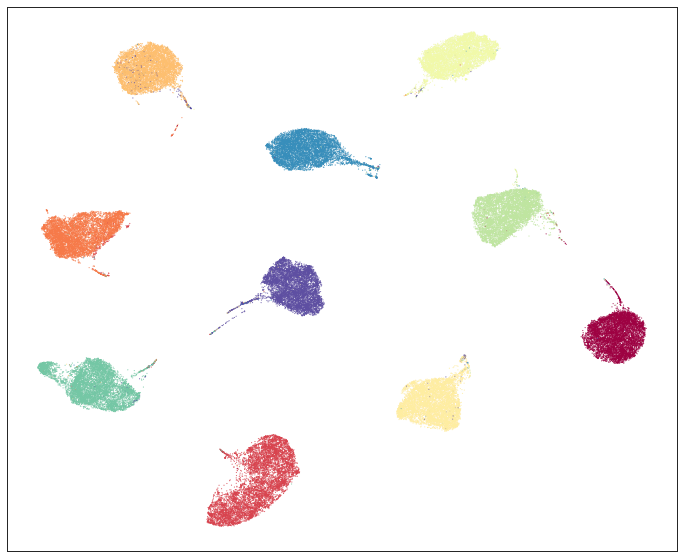

In [39]:
import umap.umap_ as umap
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="paper", style="white")

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(z)

fig, ax = plt.subplots(figsize=(12, 10))
color = y.astype(int)
plt.scatter(embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

In [40]:
# Eval.

neigh.fit(z)
_,Neighbors_list=neigh.kneighbors(z)

q, _  = model.predict([x,x[Neighbors_list[:,1]],
                       x[Neighbors_list[:,2]],
], verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(acc_fun(y, y_pred), 5)
    nmi = np.round(nmi_fun(y, y_pred), 5)
    ari = np.round(ari_fun(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

Acc = 0.98793, nmi = 0.96678, ari = 0.97324  ; loss= 0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


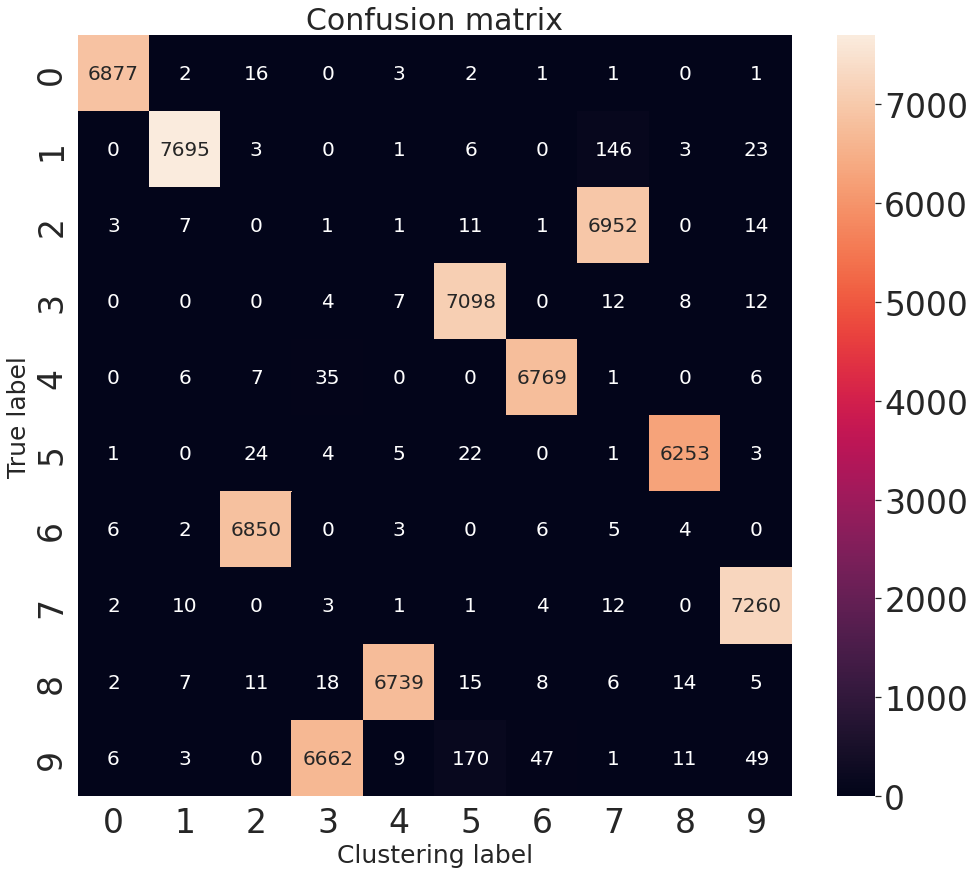

In [41]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

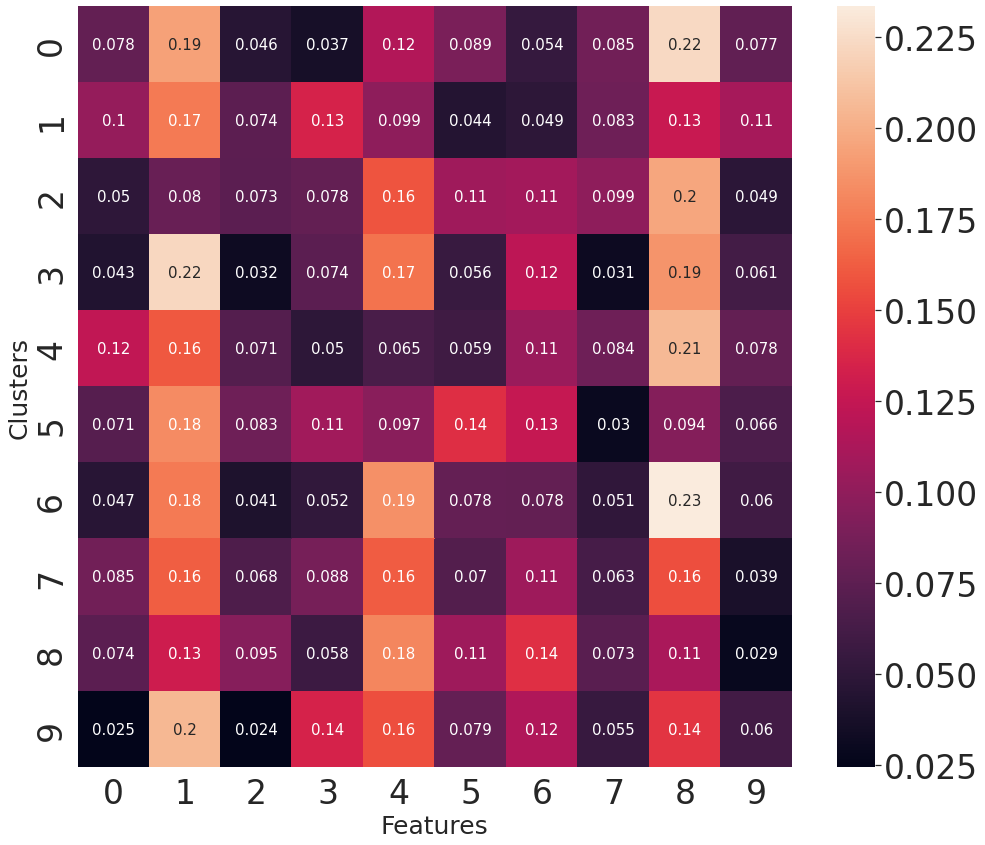

In [42]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(FeatureWeight, annot=True, annot_kws={"size": 15});
# plt.title("Feature Weight", fontsize=30)
plt.ylabel('Clusters', fontsize=25)
plt.xlabel('Features', fontsize=25)
plt.show()